random forest failed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report 
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline
pio.renderers.default='iframe'

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [2]:
df = pd.read_pickle("../../data_lake/output/train.pkl")
val = pd.read_pickle("../../data_lake/output/val.pkl")

# 2.0 EDA

In [3]:
df = df.drop(columns=['dist2','customer_id','TransactionID'])
val = val.drop(columns=['dist2','customer_id','TransactionID'])

In [4]:
df = df.rename(columns={'id_31':'browser'})
val = val.rename(columns={'id_31':'browser'})

In [5]:
df['P_emaildomain'] = df['P_emaildomain'].mask(df['P_emaildomain']=='gmail','gmail.com')
val['P_emaildomain'] = val['P_emaildomain'].mask(val['P_emaildomain']=='gmail','gmail.com')

In [6]:
df['R_emaildomain'] = df['R_emaildomain'].mask(df['R_emaildomain']=='gmail','gmail.com')
val['R_emaildomain'] = val['R_emaildomain'].mask(val['R_emaildomain']=='gmail','gmail.com')

In [7]:
df['id_30'] = df['id_30'].replace(" ","_",regex=True)
df['id_30'] = df['id_30'].str.replace(".","_",regex=False)

In [8]:
val['id_30'] = val['id_30'].replace(" ","_",regex=True)
val['id_30'] = val['id_30'].str.replace(".","_",regex=False)

In [9]:
df['browser'] = df['browser'].mask(df['browser'].str.contains('SM') | df['browser'].str.contains('ZTE'),'other')
val['browser'] = val['browser'].mask(val['browser'].str.contains('SM') | val['browser'].str.contains('ZTE'),'other')

In [10]:
df['browser'] = df['browser'].astype(str)
val['browser'] = val['browser'].astype(str)

In [11]:
df['browser_enc'] = 'other'
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('ie'),'ie')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('safari'),'safari')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('edge'),'edge')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('firefox'),'firefox')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('android'),'android')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('Android'),'android')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('chrome'),'chrome')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('opera'),'opera')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('google'),'chrome')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('samsung'),'android')

In [12]:
val['browser_enc'] = 'other'
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('ie'),'ie')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('safari'),'safari')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('edge'),'edge')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('firefox'),'firefox')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('android'),'android')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('Android'),'android')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('chrome'),'chrome')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('opera'),'opera')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('google'),'chrome')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('samsung'),'android')

In [13]:
df['DeviceType'] = df['DeviceType'].mask(df['browser']== 'ie 11.0 for tablet','tablet')
val['DeviceType'] = val['DeviceType'].mask(val['browser']== 'ie 11.0 for tablet','tablet')

In [14]:
df = df.drop(columns='browser')
val = val.drop(columns='browser')

In [15]:
df['device_info'] = df['DeviceInfo'].replace("-","_",regex=True)
df['device_info2'] = df['device_info'].replace(" ","_",regex=True)
df['device_info'] = df['DeviceInfo'].replace("-","_",regex=True)
df['device_info2'] = df['device_info'].replace(" ","_",regex=True)
df['device_info3'] = df['device_info2'].str.split("_").str[0]
df['device_info3'] = df['device_info3'].str.lower()

In [16]:
val['device_info'] = val['DeviceInfo'].replace("-","_",regex=True)
val['device_info2'] = val['device_info'].replace(" ","_",regex=True)
val['device_info'] = val['DeviceInfo'].replace("-","_",regex=True)
val['device_info2'] = val['device_info'].replace(" ","_",regex=True)
val['device_info3'] = val['device_info2'].str.split("_").str[0]
val['device_info3'] = val['device_info3'].str.lower()

In [17]:
df['device_info_v4'] = 'other'
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='windows') | (df['device_info3']=='microsoft') | (df['device_info3']=='trident/7.0')),'windows')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='ios') | (df['device_info3']=='iphone')),'ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='blade','blade')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='lenovo','lenovo')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='redmi','redmi')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='pixel','pixel')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='android','android')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='alcatel','alcatel')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='nokia','nokia')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='asus','asus')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='oneplus','oneplus')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='zte','zte')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='hisense','hisense')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='linux','linux')
df['device_info_v4'] = df['device_info_v4'].mask((df['device_info3'].str.contains("lg") | (df['device_info3'].str.contains("nexus"))),'lg')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3'].str.contains("huawei")) | (df['device_info3'].str.contains("hi6210sft"))),'huawei')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='motog3') |(df['device_info3']=='moto')),'moto')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='sm') |(df['device_info3']=='samsung')),'samsung')

In [18]:
val['device_info_v4'] = 'other'
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='windows') | (val['device_info3']=='microsoft') | (val['device_info3']=='trident/7.0')),'windows')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='ios') | (val['device_info3']=='iphone')),'ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='blade','blade')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='lenovo','lenovo')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='redmi','redmi')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='pixel','pixel')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='android','android')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='alcatel','alcatel')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='nokia','nokia')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='asus','asus')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='oneplus','oneplus')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='zte','zte')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='hisense','hisense')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='linux','linux')
val['device_info_v4'] = val['device_info_v4'].mask((val['device_info3'].str.contains("lg") | (val['device_info3'].str.contains("nexus"))),'lg')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3'].str.contains("huawei")) | (val['device_info3'].str.contains("hi6210sft"))),'huawei')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='motog3') |(val['device_info3']=='moto')),'moto')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='sm') |(val['device_info3']=='samsung')),'samsung')

In [19]:
df = df.drop(columns=['device_info','device_info2','device_info3','DeviceInfo'])
val = val.drop(columns=['device_info','device_info2','device_info3','DeviceInfo'])

In [20]:
df = df.drop(columns=['card1', 'card2', 'card3','card5', 'card6','M4', 'id_21', 'id_22',
                      'id_23','id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38']) #'
val = val.drop(columns=['card1', 'card2', 'card3','card5', 'card6','M4', 'id_21', 'id_22',
                        'id_23','id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38'])# 

In [21]:
def model_training(X_train, y_train, numerical_cols, categorical_cols,parameters):
    """
    
    """
    
    ##
    numerical_preprocessor = Pipeline(steps=[("imputer", IterativeImputer(ExtraTreesRegressor(n_estimators=5,random_state=1,verbose=0),random_state=1,verbose=0,add_indicator=True)),
                                     ("scaler", MinMaxScaler())])
    categorical_preprocessor = Pipeline(steps=[("imputer", SimpleImputer(strategy='constant', fill_value='missing',verbose=0,add_indicator=True)),
                                           ("label_enc", OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[("numerical_preprocessor", numerical_preprocessor, numerical_cols),
                                               ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])
    pipe_model = RandomForestClassifier(random_state=0)
    ##
    model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', pipe_model)])
    ##
    model.fit(X_train,y_train)
    model_grid = GridSearchCV(model,parameters,cv=4,scoring='accuracy',verbose=0,return_train_score=True).fit(X_train,y_train)
    print('GridSearchCV results...')
    print("Mean Train Scores: \n{}\n".format(model_grid.cv_results_['mean_train_score']))
    print("Mean CV Scores: \n{}\n".format(model_grid.cv_results_['mean_test_score']))
    print("Best Parameters: \n{}\n".format(model_grid.best_params_))
    
    return model_grid

In [22]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [23]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [24]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [25]:
parameters = {'model__max_depth':[2,4,6,10],'model__n_estimators':[100,200,400.1000]}

In [26]:
model = model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/anaconda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 349, in fit
    self._validate_estimator()
  File "/anaconda/lib/python3.9/site-packages/sklearn/ensemble/_base.py", line 129, in _validate_estimator
    raise ValueError("n_estimators must be an integer, "
ValueError: n_estimators must be an integer, got <class 'float'>.


/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: Fit

GridSearchCV results...
Mean Train Scores: 
[0.64615283 0.64233226        nan 0.68736806 0.68446115        nan
 0.7282506  0.72768989        nan 0.78881706 0.78919065        nan]

Mean CV Scores: 
[0.64594422 0.64208261        nan 0.68761557 0.68294408        nan
 0.72287209 0.72175148        nan 0.76884213 0.76946526        nan]

Best Parameters: 
{'model__max_depth': 10, 'model__n_estimators': 200}



In [27]:
def model_evaluation(model,X_test,y_test):
    """
    
    """
    print('Test results...')
    y_test_predict_grid = model.predict(X_test)    
    print("Model Test Accuracy:", metrics.accuracy_score(y_test, y_test_predict_grid))
    print('--------------------------------------------------')
    print('Model Test Confusion Matrix')
    cm = confusion_matrix(y_test,y_test_predict_grid,normalize='true') 
    cmd = ConfusionMatrixDisplay(cm,display_labels=['No','Yes'])
    cmd.plot()
    print('Classification report : \n',classification_report(y_test, y_test_predict_grid))

    ##
    feature_importances = model.best_estimator_.named_steps['model'].feature_importances_
    feature_names = X_test.columns
    lista = []
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    #         print('{}: {}'.format(name, score))
            lista.append(name)
    print('First ten features by importances:')
    print(lista[0:15])
    
    return model

In [28]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [29]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

Test results...
Model Test Accuracy: 0.7268777443956552
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     19976
         1.0       0.19      0.82      0.31      1659

    accuracy                           0.73     21635
   macro avg       0.59      0.77      0.57     21635
weighted avg       0.92      0.73      0.79     21635

First ten features by importances:
['ProductCD', 'card4', 'TransactionAmt', 'R_emaildomain', 'id_32', 'id_30', 'id_33', 'num_transactio_per_time', 'max_c', 'id_34', 'DeviceType', 'addr1', 'addr2', 'device_info_v4', 'browser_enc']


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_preprocessor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer(add_indicator=True,
                                                                                                           estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                                         random_state=1),
                                                                                                           random_state=1)),
                                                                                         ('scaler',
                                                                  

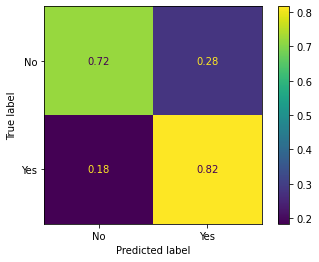

In [30]:
model_evaluation(model,X_val,y_val)

In [31]:
df['proba'] = model.predict_proba(df[X_train.columns])[:,1]
val['proba'] = model.predict_proba(val[X_train.columns])[:,1]

In [32]:
val.sample(3)

,isFraud,TransactionAmt,ProductCD,card4,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_32,id_33,id_34,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
139224,0,150.0,R,american express,327.0,87.0,anonymous.com,anonymous.com,Windows_7,24.0,1920x1080,match_status:2,desktop,1.0,0.000000,1,0,ie,other,0.145849
85796,0,100.0,R,visa,337.0,87.0,aol.com,gmail.com,nan,nan,nan,match_status:2,mobile,1.0,0.875000,1,0,chrome,samsung,0.313945
3415,0,250.0,R,american express,269.0,87.0,anonymous.com,gmail.com,nan,nan,nan,nan,desktop,818.0,53.791664,1,0,ie,other,0.480360


In [33]:
df.sample(3)

,isFraud,TransactionAmt,ProductCD,card4,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_32,id_33,id_34,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
19137,0,25.000,H,visa,226.0,87.0,gmail.com,gmail.com,Windows_10,24.0,1366x768,match_status:2,desktop,1.0,259.041656,1,0,chrome,windows,0.280859
37349,0,25.069,C,mastercard,nan,nan,live.com.mx,live.com.mx,nan,nan,nan,nan,desktop,3.0,0.083333,1,0,chrome,windows,0.503792
80560,0,162.409,C,visa,nan,nan,hotmail.com,hotmail.com,nan,nan,nan,nan,mobile,1.0,0.000000,1,0,chrome,other,0.412322


In [34]:
val['isFraud'].value_counts()

0    19976
1     1659
Name: isFraud, dtype: int64

In [35]:
val[val['isFraud']=='1'].sample(3)

,isFraud,TransactionAmt,ProductCD,card4,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_32,id_33,id_34,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
93042,1,15.891,C,mastercard,nan,nan,hotmail.com,hotmail.com,nan,nan,nan,nan,mobile,8.0,518.000000,1,0,safari,other,0.600971
101450,1,11.359,C,visa,nan,nan,hotmail.com,hotmail.com,nan,nan,nan,nan,desktop,24.0,236.000000,1,0,chrome,moto,0.650804
77715,1,250.000,R,visa,191.0,87.0,gmail.com,gmail.com,Windows_7,24.0,1920x1080,match_status:2,desktop,5.0,160.791672,1,0,chrome,windows,0.446899
